In [1]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image
from diffusers import AutoPipelineForText2Image, StableDiffusionPipeline
from train_video import RateDistortionLoss
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration
import numpy as np
from utils import *
from torchvision import transforms
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/data/maryam.sana/anaconda3/envs/compressai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
img_path = 'data/custom_data/train/img00002.png'
image = Image.open(img_path)
print('size:', image.size) 
image_resized = image.resize((512,512))

size: (1920, 1080)


In [3]:
def psnr(a: torch.Tensor, b: torch.Tensor, max_val: int = 255) -> float:
    return 20 * math.log10(max_val) - 10 * torch.log10((a - b).pow(2).mean())

In [4]:
## psnr experiment 

post_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    lambda x: x * 255 
])
image_tensor = post_transform(image)
noise_std = 0.5  # This value can be adjusted based on your specific needs
noise = torch.randn_like(image_tensor) * noise_std
noisy_image = image_tensor + noise

print('psnr : ', psnr(image_tensor,image_tensor).item())
print('psnr : ', psnr(image_tensor,noisy_image).item())


psnr :  inf
psnr :  54.13977813720703


In [5]:
img2 = post_transform(Image.open('results/edited_image_dog.png'))

print('psnr : ', psnr(image_tensor,img2).item())

psnr :  9.67496109008789


In [6]:
horizontal_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    lambda x: x * 255 ])

img2 = horizontal_transform(image)

print('psnr : ', psnr(image_tensor,img2).item())

psnr :  13.753528594970703


PSNR for std 0.1: 68.28
PSNR for std 0.2: 62.70
PSNR for std 0.3: 59.85
PSNR for std 0.4: 58.22
PSNR for std 0.5: 57.21
PSNR for std 0.6: 56.51
PSNR for std 0.7: 56.02
PSNR for std 0.8: 55.67
PSNR for std 0.9: 55.40
PSNR for std 1.5: 54.56


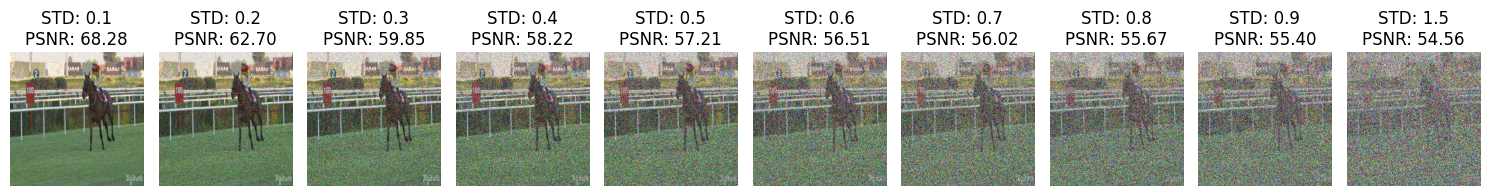

In [7]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Assume `image` is a PIL image loaded prior to this code
post_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor()
])

image_tensor = post_transform(image)
std_levels = [0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1.5]
fig, axes = plt.subplots(1, len(std_levels), figsize=(15, 5))

for i, std in enumerate(std_levels):
    noise = torch.randn_like(image_tensor) * std
    noisy_image = image_tensor + noise
    noisy_image_clamped = noisy_image.clamp(0, 1)  # Clamp values to maintain valid image range

    # Compute and print PSNR
    psnr_value = psnr(image_tensor, noisy_image_clamped,255)
    print(f'PSNR for std {std}: {psnr_value:.2f}')

    # Convert tensor to PIL for display
    display_image = to_pil_image(noisy_image_clamped)
    axes[i].imshow(display_image)
    axes[i].set_title(f'STD: {std}\nPSNR: {psnr_value:.2f}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
